In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
sns.set_context("notebook")

In [4]:
# load population data and rename columns
pop = pd.read_csv('State Populations.csv')
pop.columns = ['state','pop']
pop.head()

,state,pop
0,California,39776830
1,Texas,28704330
2,Florida,21312211
3,New York,19862512
4,Pennsylvania,12823989


In [18]:
# load state covid data and merge with pop data
s = pd.read_csv('us-states.txt')
s = pd.merge(s, pop, on='state')
s.head()

,date,state,fips,cases,deaths,pop
0,2020-01-21,Washington,53,1,0,7530552
1,2020-01-22,Washington,53,1,0,7530552
2,2020-01-23,Washington,53,1,0,7530552
3,2020-01-24,Washington,53,1,0,7530552
4,2020-01-25,Washington,53,1,0,7530552


In [25]:
# add in cases_per_1000 col
s['cases_per_1000'] = s['cases'] / s['pop'] * 1000
s.head()

,date,state,fips,cases,deaths,pop,cases_growth,cases_per_1000
0,2020-01-21,Washington,53,1,0,7530552,NaN,0.000133
1,2020-01-22,Washington,53,1,0,7530552,NaN,0.000133
2,2020-01-23,Washington,53,1,0,7530552,NaN,0.000133
3,2020-01-24,Washington,53,1,0,7530552,NaN,0.000133
4,2020-01-25,Washington,53,1,0,7530552,NaN,0.000133


In [26]:
def rolling_growth_by_group(df, group_col, value_col, window=5):
    return df.groupby(group_col)[value_col].pct_change().rolling(window=window).mean()

s['cases_growth'] = rolling_growth_by_group(s, 'state', 'cases')

# just looking at output
s.query('state == "New York" and cases > 100').head(10)

,date,state,fips,cases,deaths,pop,cases_growth,cases_per_1000
654,2020-03-08,New York,36,106,0,19862512,1.542748,0.005337
655,2020-03-09,New York,36,142,0,19862512,0.710672,0.007149
656,2020-03-10,New York,36,173,0,19862512,0.554334,0.008710
657,2020-03-11,New York,36,217,0,19862512,0.405201,0.010925
658,2020-03-12,New York,36,326,0,19862512,0.301117,0.016413
659,2020-03-13,New York,36,421,0,19862512,0.321197,0.021196
660,2020-03-14,New York,36,610,2,19862512,0.343058,0.030711
661,2020-03-15,New York,36,732,6,19862512,0.339396,0.036853
662,2020-03-16,New York,36,950,10,19862512,0.348092,0.047829
663,2020-03-17,New York,36,1374,17,19862512,0.336894,0.069176


In [27]:
def filter_column_by_values(df, filter_column, values):
    return df[df[filter_column].isin(values)]

states = ['California', 'Hawaii', 'Massachusetts', 'New York']
filtered_s = filter_column_by_values(s, 'state', states)

# just looking at output
filtered_s['state'].unique()

array(['California', 'Massachusetts', 'New York', 'Hawaii'], dtype=object)

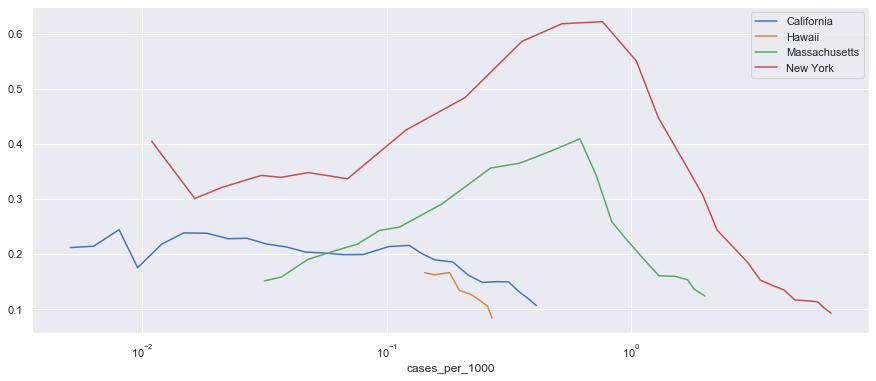

In [32]:
def graph_multiseries(df, series, x, y, logx=True):
    df = df.query('cases > 200')
    
    fig, ax = plt.subplots(figsize=(15,6))
    for key, grp in df.groupby([series]):
        ax = grp.plot(ax=ax, kind='line', x=x, y=y, label=key, logx=logx)
    plt.legend(loc='best')
    plt.show()

    
graph_multiseries(filtered_s, 'state', 'cases_per_1000', 'cases_growth')

### Most Problematic States

In [45]:
current = s.groupby('state')[['cases_per_1000','cases_growth']].last()
current.head()

,cases_per_1000,cases_growth
state,,
Alabama,0.410313,0.127557
Alaska,0.256074,0.057820
Arizona,0.346018,0.117899
Arkansas,0.306920,0.083331
California,0.409384,0.106748


In [51]:
current['L2'] = np.sqrt(current['cases_per_1000']**2 + current['cases_growth']**2)
current.sort_values(by='L2', ascending=False).head(10)

,cases_per_1000,cases_growth,L2
state,,,
New York,6.580386,0.092968,6.581043
New Jersey,4.548941,0.130843,4.550822
Louisiana,3.175007,0.189426,3.180653
Massachusetts,2.006550,0.123832,2.010367
Connecticut,1.924383,0.145271,1.929858
Michigan,1.714513,0.130559,1.719477
District of Columbia,1.559107,0.134155,1.564868
Washington,1.113331,0.085513,1.116611
Pennsylvania,1.019496,0.176773,1.034708


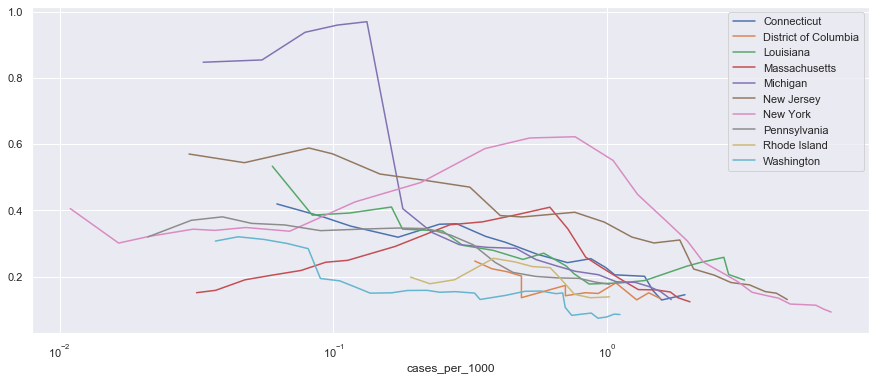

In [55]:
states = current.sort_values(by='L2', ascending=False).head(10).index.tolist()

filtered_s = filter_column_by_values(s, 'state', states)
graph_multiseries(filtered_s, 'state', 'cases_per_1000', 'cases_growth')